In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from statsmodels.tsa.api import VAR
import networkx as nx
import matplotlib.pyplot as plt
import os,sys
import seaborn as sns
import missingno as msno
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')  
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")






# 网络拓扑属性
class MyGraph():
    def __init__(self, adj_matrix):
        """
        adj_matrix: 邻接矩阵
        """
        #self.adj_matrix = adj_matrix / len(adj_matrix)  # 在每个子网络输入的时候 除以他们的节点数来惩罚
        #self.adj_matrix = scale_one(adj_matrix)
        self.adj_matrix = adj_matrix.copy()

        #self.adj_matrix = adj_matrix / adj_matrix.max().max()
        
        self.init_graph()
        
    def init_graph(self):
        self.g = ig.Graph(directed=True)
        for i in self.adj_matrix.columns:
            self.g.add_vertex(name=i)

        edges = []
        node_labels = self.adj_matrix.columns.values
        weights = []
        for i in (range(self.adj_matrix.shape[0])):
            for j in range(self.adj_matrix.shape[0]):
                if self.adj_matrix.iloc[i, j] != 0 and not np.isnan(self.adj_matrix.iloc[i, j]): 
                    edges.append((i, j))
                    weights.append(self.adj_matrix.iloc[i, j])
        self.g.add_edges(edges)
        self.g.vs['name'] = node_labels
        self.g.vs["label"] = self.g.vs['name']
        self.g.es['weight'] = weights


    def profile(self):
        """
        describe network with key indicators
        """
        #print('stats profile...')
        g = self.g
        weights = self.g.es['weight']
        properties_dict = {
            "节点数": g.vcount(),
            "边数": g.ecount(),
            '是否有向': g.is_directed(),
            '是否加权': g.is_weighted(),
            "节点度数:": g.degree(),
            '最大度': max(g.degree()),
            #'平均度': round(np.sum(self.adj_matrix.values -  np.eye(self.adj_matrix.shape[0], self.adj_matrix.shape[1]) * self.adj_matrix), 5),
            "网络直径": round(g.diameter(weights=weights), 5),
            "平均路径长度": round(g.average_path_length(), 5),
            "度中心性:": g.strength(weights=weights),
            "接近中心性:": g.closeness(weights=weights),
            "中介中心性:": g.betweenness(weights=weights),
            '特征向量中心性': g.evcent(weights=weights),  # 计算特征向量中心性
            '平均介数中心性betweenness': round(np.mean(g.betweenness(weights=weights)), 5),
            '平均接近中心性closeness': round(np.mean(g.closeness(weights=weights)), 5),
            '聚类系数': np.mean(g.transitivity_local_undirected()),
        }
        return properties_dict


    def plot_adj_matrix_hist(self, figsize=(6, 4)):
        """
        plot histogram of adj-matrix
        """
        pd.DataFrame(self.adj_matrix.values.flatten()).hist(figsize=figsize)

    
    def plot_circle(self, figsize=(6, 4), vertex_color="lightblue"):
        """
        plot network at form of "circle"
        """
        layout = self.g.layout("circle")  #fr
        visual_style = {
            "vertex_size": 20,
            "vertex_color": "blue",
            "vertex_label": self.g.vs["name"],
            "edge_width": 2,
            "layout": layout
        }
        fig, ax = plt.subplots(figsize=figsize)
        ig.plot(self.g, target=ax, **visual_style)
        plt.show()

    
    def plot_clusters(self, figsize=(6,4), vertex_size=0.5, edge_width=0.7):
        """
        plot network at form of "clusters"
        """
        components = self.g.connected_components()
        fig, ax = plt.subplots(figsize=figsize)
        ig.plot(
            components,
            target=ax,
            palette=ig.RainbowPalette(),
            vertex_size=vertex_size,
            vertex_color=list(map(int, ig.rescale(components.membership, (0, 200), clamp=True))),
            edge_width=edge_width
        )
        plt.show()

    
    def communities_clustering(self):
        """
        使用边介数法进行社区检测
        """
        communities = self.g.community_edge_betweenness()
        clusters = communities.as_clustering()
        print("社区划分:", clusters.membership)

        
        
    # 计算网络信息熵
    def calculate_information_entropy(self, W):
        W = W.values
        n = W.shape[0]
        #P = W / np.sum(W, axis=1, keepdims=True)  # 归一化邻接矩阵
        P = W.copy()
        entropy = -np.sum(P * np.log(P + 1e-10))  # 计算信息熵，防止对数为负无穷

        return entropy
    
    
    # 计算方差分解强度
    def cal_spillover_strength2(self, df):

        np.fill_diagonal(df.values, 0)
        IS = df.sum(axis = 0)
        OS = df.sum(axis =1)
        NS = OS - IS
        #print (NS)
        return IS.values, OS.values, NS.values





# 网络构建
class complex_network():
    def __init__(self):
        return

    def compute_gfevd(self, H, A, sigma_u):
        n_vars = A.shape[1]
        gfevd = np.zeros((n_vars, n_vars))
        e = np.eye(n_vars)

        A_sigma_u = np.array([A[h] @ sigma_u for h in range(H)])
        eA_sigma_u = np.array([[e[i].T @ A_sigma_u[h] for h in range(H)] for i in range(n_vars)])
        den_cache = np.array([np.sum([eA_sigma_u[i, h] @ A[h].T @ e[i] for h in range(H)]) for i in range(n_vars)])

        for i in (range(n_vars)):
            for j in range(n_vars):
                num = 1. / sigma_u[j, j] * np.sum([(eA_sigma_u[i, h] @ e[j]) ** 2 for h in range(H)])
                gfevd[i, j] = num / den_cache[i]

        return gfevd
    

    
    def compute_gfevd_ori(self, H, A, sigma_u ):
        n_vars = A.shape[1]
        gfevd = np.zeros((n_vars, n_vars))
        e = np.eye(n_vars)

        for i in tqdm(range(n_vars)):
            for j in range(n_vars):
                if sigma_u[j,j] == 0:
                    gfevd[i,j] = 0
                    continue

                num = 1. / sigma_u[j, j] * np.sum([(e[i].T @ A[h] @ sigma_u @ e[j]) ** 2 for h in range(H)]) 
                den = np.sum([(e[i].T @ A[h] @ sigma_u @ A[h].T @ e[i]) for h in range(H)])
                gfevd[i, j] = num / den

        return gfevd
    
    
    
    def get_eod_price(self):

        close_df = pd.read_feather('stock_price/Close.feather')
        close_df.index = close_df['time']
        close_df = close_df.iloc[:, 1:]

        open_df = pd.read_feather('stock_price/Open.feather')
        open_df.index = open_df['time']
        open_df = open_df.iloc[:, 1:]

        high_df = pd.read_feather('stock_price/High.feather')
        high_df.index = high_df['time']
        high_df = high_df.iloc[:, 1:]

        low_df = pd.read_feather('stock_price/Low.feather')
        low_df.index = low_df['time']
        low_df = low_df.iloc[:, 1:]


        #hz_path = r'D:\BaiduSyncdisk\papers\ESG\ESG评级大合集\华证2009-2023年（含细分项+季度)）\3-华证ESG评级和得分（2009-2023）\华证ESG评级-得分2009-2023.xlsx'
        hz_path = 'D:\BaiduSyncdisk\papers\ESG\ESG评级大合集\华证2009-2023年（含细分项+季度)）\华证esg评级2009-2023（细分项）\华证esg评级含细分项（季度）2009-2023.xlsx'
        df_hz_esg = pd.read_excel(hz_path)
        #df_hz_esg['年份'].unique()

        #df_hz_esg[df_hz_esg['年份'] == 2023].to_csv('test.csv')


        # 应用函数到 '股票代码' 列
        df_hz_esg['股票代码'] = df_hz_esg['证券代码'].apply(pad_stock_code)

        df_hz_esg = df_hz_esg.set_index('股票代码')
        df_hz_esg = df_hz_esg.drop('证券代码', axis =1 )

        return open_df, high_df, low_df, close_df, df_hz_esg


    

# Function to generate specific dates for each year from 2013 to 2023


# Generate dates from 2013 to 2023 for the specific day-month pairs
# List of specific day-month pairs
day_month_pairs = [(1, 31), (4, 30), (7, 31), (10, 31)]
start_year = 2013
end_year = 2023
generated_dates = generate_dates(start_year, end_year, day_month_pairs)


#generated_dates
    
    
    
CN = complex_network()
open_df, high_df, low_df, close_df, df_hz_esg = CN.get_eod_price()
vol_interday = calculate_volatility(open_df, high_df, low_df, close_df)

#import datetime
df_hz_esg#[pd.to_datetime(df_hz_esg['评级日期']).dt.date == datetime.date(2019,1,31)]

# 构建网络并计算方差分解矩阵

In [82]:

# months = [datetime.date(2019,10,31), datetime.date(2020,1,31),datetime.date(2020,4,30), datetime.date(2020,7,31), datetime.date(2020,10,31),]
# months = [datetime.date(2019,1,31),datetime.date(2021,1,31)]
# months = [datetime.date(2014,7,31),datetime.date(2015,7,31), datetime.date(2016,7,31)]
months = generated_dates.copy()

steps = 10
for i in tqdm(months):
    
    df_hz_esg_i = df_hz_esg[pd.to_datetime(df_hz_esg['评级日期']).dt.date == i]
    code_list_i = np.intersect1d(df_hz_esg_i.index.values, close_df.columns.values)

    #vol_interday_i = vol_interday[vol_interday.index.year == i]
    start_date, end_date = get_quarter_dates(i)

    vol_interday_i = vol_interday[(vol_interday.index.date >= start_date) & (vol_interday.index.date <= end_date)]
    code_list_i = np.intersect1d(vol_interday.columns.values, code_list_i)
    volatilities_i = vol_interday_i[code_list_i]

    volatilities_i = volatilities_i.loc[:, (volatilities_i.isnull().sum()>20) == False].fillna(method = 'ffill').fillna(method ='pad')
    
    volatilities_i = volatilities_i.dropna(axis = 1)

    #P平稳性检验
    volatilities_i = stable_check(volatilities_i)
    
    # 标准化
    #volatilities_i = (volatilities_i - volatilities_i.mean()) / volatilities_i.std()
    #volatilities_i = volatilities_i.dropna()
    print (volatilities_i.shape)
    
    
    
    # 全部都是一样的数据删除
    constant_columns = volatilities_i.columns[volatilities_i.nunique() < 5]
    # 删除这些列
    volatilities_i = volatilities_i.drop(columns=constant_columns)
    #volatilities_i = volatilities_i.iloc[-70:,-200:]

    
    #计算方差分解的矩阵  这里是全网络的生成
    returns = volatilities_i.copy()
    model = VAR(returns)
    results = model.fit(2)
    # 获取模型残差的协方差矩阵及其逆矩阵    
    # resid = results.resid
    # cov_matrix = np.cov(resid, rowvar=False)
    # sigma_u2 =cov_matrix
    
    sigma_u = results.sigma_u.values
    A = results.ma_rep(steps)
    H = 5
    
    #NX = 
    gfevd = CN.compute_gfevd(H, A, sigma_u)
    gfevd_df = pd.DataFrame(gfevd, index=volatilities_i.columns, columns=volatilities_i.columns)
    
    
    #print (gfevd_df)
    #break
    
    # 按行做归一化
    #gfevd_df_nor = normalize_rows_with_non_negative(gfevd_df)
    
    
    gfevd_df.to_csv('output_month/' + str(i) + '.csv')
    

  0%|          | 0/44 [00:00<?, ?it/s]

(56, 1873)
(57, 1277)
(64, 1758)
(61, 1752)
(58, 1776)
(61, 1702)
(65, 1580)
(61, 1619)
(57, 1598)
(62, 1111)
(64, 1840)
(61, 1790)
(59, 1838)
(61, 2013)
(64, 1867)
(60, 2096)
(59, 2129)
(60, 2196)
(65, 2173)
(60, 2543)
(59, 2553)
(60, 2458)
(64, 2735)
(60, 2629)
(58, 2525)
(60, 2695)
(65, 3115)
(61, 2908)
(58, 2833)
(59, 2928)
(66, 2653)
(60, 3090)
(58, 3225)
(60, 3316)
(64, 3389)
(61, 3472)
(58, 3842)
(59, 3503)
(65, 3993)
(60, 3745)
(59, 4067)
(59, 4032)
(64, 3927)
(60, 3845)


# 做成方差分解的两两传输矩阵

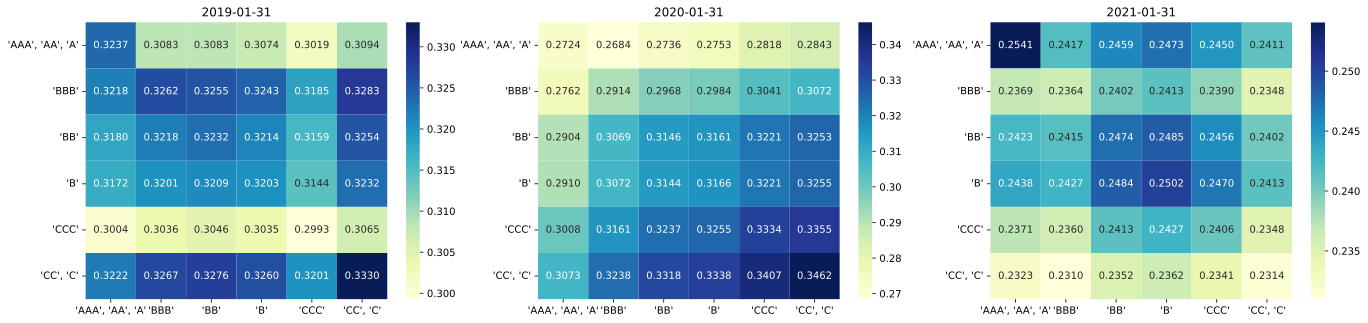

In [173]:
analisys_months = months.copy()
#analisys_months = [datetime.date(2019,7,31), datetime.date(2019,10,31), datetime.date(2020,1,31),datetime.date(2020,4,30), datetime.date(2020,7,31), datetime.date(2020,10,31),]
analisys_months = [datetime.date(2019,1,31), datetime.date(2020,1,31), datetime.date(2021,1,31)]
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(23, 5))

#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(18, 6))

for num, month_ in enumerate(analisys_months):

    #df_hz_esg_i = df_hz_esg[df_hz_esg['年份'] == year]

    
    
    
    df_hz_esg_i = df_hz_esg[pd.to_datetime(df_hz_esg['评级日期']).dt.date == month_]

    
    #year = 2015
    df = pd.read_csv('output_month/%s.csv'%month_,)
    #df_hz_esg_i = df_hz_esg[df_hz_esg['年份'] == month_]

    df.code = df.code.apply(pad_stock_code)
    df = df.set_index(df.code)
    df = df.drop(['code'], axis =1 )

    #合并两个矩阵的交集
    intersection = list(set(df.index.tolist()).intersection(set(df_hz_esg_i.index.tolist())))
    df = df.loc[intersection, intersection]
    df_hz_esg_i = df_hz_esg_i.loc[intersection]
    
    
    rate_list = [['AAA', 'AA', 'A'], ['BBB'], ['BB'], ['B'], ['CCC'], ['CC', 'C']]
    j = rate_list[0]

    ns_list = {}
    for k in rate_list:
        ns_list[str(k).replace('[', '').replace(']', '')] = {}
        for n in rate_list:
            rate_j_list1 = np.array(df_hz_esg_i[df_hz_esg_i['综合评级'].isin(k)].index.tolist())
            rate_j_list2= np.array(df_hz_esg_i[df_hz_esg_i['综合评级'].isin(n)].index.tolist())

            df3 = df.loc[rate_j_list1 , rate_j_list2]
            df4 = df.loc[rate_j_list2 , rate_j_list1]

            ns_list[str(k).replace('[', '').replace(']', '')][str(n).replace('[', '').replace(']', '')] = df3.sum().sum() / (df3.size)

    ns_list = pd.DataFrame(ns_list)
    sns.heatmap(ns_list, annot=True, ax = eval('ax%s'%(num+1)), cmap='YlGnBu', fmt='.4f')
    eval('ax%s'%(num+1)).set_title(month_)


#plt.xlabel('Rating List')
#plt.ylabel('Rating List')
plt.savefig('evfd_month.jpg')

In [190]:
#df
#df

def list_to_mean(x):
    if isinstance(x, list):
        return sum(x) / len(x)
    else:
        return x

# 使用 applymap 方法应用函数到 DataFrame 的每个元素
# df_result_mean = df_result.applymap(list_to_mean)
# df_result_mean.to_csv('test_result.csv')

# 做成全网的溢出时间序列

In [189]:
df_centrality = pd.DataFrame()

for month_ in tqdm(months[:1]):
    df = pd.read_csv('topological_properties_month/%s_result.csv'%month_, index_col = 0)
    #df.code = df.code.apply(pad_stock_code)
    #df = df.set_index(df.code)
    #df = df.drop(['code'], axis =1 )
    np.fill_diagonal(df.values, 0)
    
    rate_list_str = [", ".join(sublist) for sublist in rate_list]

    #print(rate_list_str)
    df.index = np.array(rate_list_str)
    df_result = df.applymap(list_to_mean)
    print (df_result)
    

    df_hz_esg_i = df_hz_esg[pd.to_datetime(df_hz_esg['评级日期']).dt.date == month_]

    df_hz_esg_i = df_hz_esg_i.loc[df.columns]
    df_hz_esg_i.loc[:,'rating_score'] = df_hz_esg_i['综合评级']
    
    
    is_list = []
    os_list = []
    ns_list = []
    
    for j in rate_list:
        
        
        rate_j_list = df_hz_esg_i[df_hz_esg_i['rating_score'].isin(j)].index.tolist()
        #print (j, IS[IS.index.isin(rate_j_list)].mean(), OS[OS.index.isin(rate_j_list)].mean(), NS[NS.index.isin(rate_j_list)].mean())
        
        is_list.append(IS[IS.index.isin(rate_j_list)].mean())
        os_list.append(OS[OS.index.isin(rate_j_list)].mean())
        ns_list.append(NS[NS.index.isin(rate_j_list)].mean())
    df_is = pd.concat([df_is, pd.Series(is_list)], axis =1 )
    df_os = pd.concat([df_os, pd.Series(os_list)], axis = 1)
    df_ns = pd.concat([df_ns, pd.Series(ns_list)], axis =1 )
    
df_is.columns = months
df_os.columns = months
df_ns.columns = months
#df_ns.index = np.array(rate_list)


# list 不能直接作为dataframe的index 必须转成str
rate_list_str = [", ".join(sublist) for sublist in rate_list]

#print(rate_list_str)
df_ns.index = np.array(rate_list_str)


df = df_ns.T#copy()
fig, axs = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)
fig.suptitle('Net Spillover Intensity of Various ESG Ratings')



#titles = ['ESG', 'Bond', 'Interbank', 'FX']
titles = df.columns
for ax, title in zip(axs.ravel(), titles):
    ax.plot(df.index, df[title], color='black')
    #ax.bar(df.index, df[title], color='black', width=20)

    ax.set_title(title)
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_xlim(df.index[0], df.index[-1])
    ax.set_ylim(-120, 120)

for ax in axs.flat:
    ax.label_outer()

#fig.text(0.5, 0.04, 'Time', ha='center')
#fig.text(0.04, 0.5, 'Return Spillovers', va='center', rotation='vertical')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.show()
plt.savefig('pics/spillover_time_series.jpg')

  0%|          | 0/1 [00:00<?, ?it/s]

            节点数      边数  是否有向  是否加权    节点度数   最大度     网络直径  平均路径长度  \
AAA, AA, A    5      25  True  True    10.0    10  0.00068     1.0   
BBB         136   18496  True  True   272.0   272  0.00062     1.0   
BB          611  373321  True  True  1222.0  1222  0.00048     1.0   
B           731  534361  True  True  1462.0  1462  0.00038     1.0   
CCC         288   82944  True  True   576.0   576  0.00056     1.0   
CC, C       102   10404  True  True   204.0   204  0.00057     1.0   

                                                         度中心性  \
AAA, AA, A  [0.007036319042148724, 0.007593979779688858, 0...   
BBB         [0.12761837881126423, 0.14165715774943352, 0.1...   
BB          [0.6224731573646456, 0.7496506097644353, 0.506...   
B           [0.6285049287313711, 0.7959691399339277, 0.974...   
CCC         [0.3589644992119149, 0.45164369743855814, 0.40...   
CC, C       [0.10038505237366101, 0.1321417527296785, 0.10...   

                                                     

KeyError: "None of [Index(['节点数', '边数', '是否有向', '是否加权', '节点度数', '最大度', '网络直径', '平均路径长度', '度中心性',\n       '接近中心性', '中介中心性', '特征向量中心性', '平均介数中心性betweenness', '平均接近中心性closeness'],\n      dtype='object')] are in the [index]"

  0%|          | 0/44 [00:00<?, ?it/s]

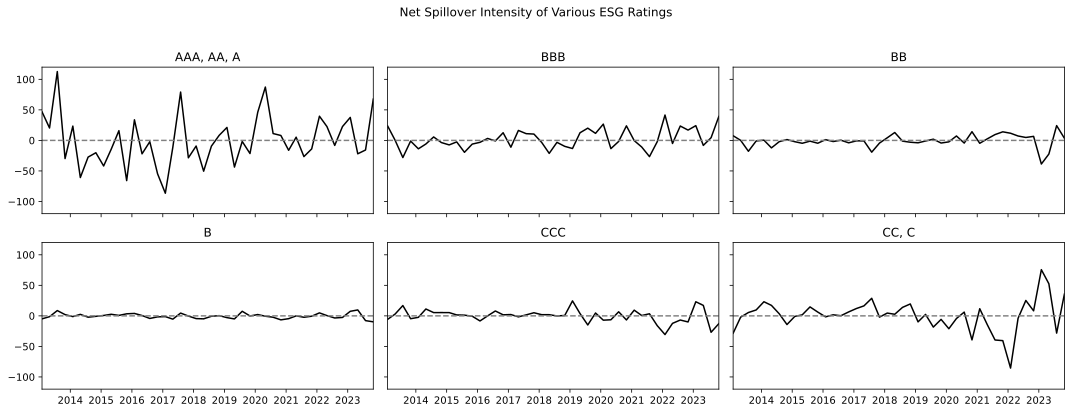

In [167]:
df_is = pd.DataFrame()
df_os = pd.DataFrame()
df_ns = pd.DataFrame()

for month_ in tqdm(months):
    df = pd.read_csv('output_month/%s.csv'%month_)
    df.code = df.code.apply(pad_stock_code)
    df = df.set_index(df.code)
    df = df.drop(['code'], axis =1 )
    np.fill_diagonal(df.values, 0)
    IS = df.sum(axis = 0)
    OS = df.sum(axis =1)
    NS = OS - IS
    #print (NS)
    IS, OS, NS
    #df_hz_esg_i = df_hz_esg[df_hz_esg['年份'] == month_]
    df_hz_esg_i = df_hz_esg[pd.to_datetime(df_hz_esg['评级日期']).dt.date == month_]

    df_hz_esg_i = df_hz_esg_i.loc[df.columns]
    df_hz_esg_i.loc[:,'rating_score'] = df_hz_esg_i['综合评级']
    
    
    is_list = []
    os_list = []
    ns_list = []
    
    for j in rate_list:
        
        
        rate_j_list = df_hz_esg_i[df_hz_esg_i['rating_score'].isin(j)].index.tolist()
        #print (j, IS[IS.index.isin(rate_j_list)].mean(), OS[OS.index.isin(rate_j_list)].mean(), NS[NS.index.isin(rate_j_list)].mean())
        
        is_list.append(IS[IS.index.isin(rate_j_list)].mean())
        os_list.append(OS[OS.index.isin(rate_j_list)].mean())
        ns_list.append(NS[NS.index.isin(rate_j_list)].mean())
    df_is = pd.concat([df_is, pd.Series(is_list)], axis =1 )
    df_os = pd.concat([df_os, pd.Series(os_list)], axis = 1)
    df_ns = pd.concat([df_ns, pd.Series(ns_list)], axis =1 )
    
df_is.columns = months
df_os.columns = months
df_ns.columns = months
#df_ns.index = np.array(rate_list)


# list 不能直接作为dataframe的index 必须转成str
rate_list_str = [", ".join(sublist) for sublist in rate_list]

#print(rate_list_str)
df_ns.index = np.array(rate_list_str)


df = df_ns.T#copy()
fig, axs = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)
fig.suptitle('Net Spillover Intensity of Various ESG Ratings')



#titles = ['ESG', 'Bond', 'Interbank', 'FX']
titles = df.columns
for ax, title in zip(axs.ravel(), titles):
    ax.plot(df.index, df[title], color='black')
    #ax.bar(df.index, df[title], color='black', width=20)

    ax.set_title(title)
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_xlim(df.index[0], df.index[-1])
    ax.set_ylim(-120, 120)

for ax in axs.flat:
    ax.label_outer()

#fig.text(0.5, 0.04, 'Time', ha='center')
#fig.text(0.04, 0.5, 'Return Spillovers', va='center', rotation='vertical')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.show()
plt.savefig('pics/spillover_time_series.jpg')

# 描述性统计

In [139]:
#df_hz_esg_i

# 描述统计
#for i in df_hz_esg.groupby('年份'):
#    print (i[-1]['综合评级'].value_counts())
df_t = pd.DataFrame(df_hz_esg.groupby('年份')['综合评级'].value_counts())
#.pivot(index='first', columns='second', values='value')
df_t = df_t.unstack()#.pivot_table()
df_t.columns = df_t.columns.droplevel(0)


df_t = df_t[df_t.index >= 2013]
df_t = df_t[['AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C']]
df_t.to_csv('esg_descrbe.csv')vol_interday = vol_interday[(vol_interday.index.year >= 2013) & ((vol_interday.index.year <= 2023))]
vol_des = vol_interday.describe()

skewness = vol_interday.skew()
kurtosis = vol_interday.kurt()
vol_des.loc['skewness'] = skewness
vol_des.loc['kurtosis'] = kurtosis


#df_hz_esg_i['综合评级'].value_counts()

#df_hz_esg_i = df_hz_esg
# df_hz_esg_i = df_hz_esg[df_hz_esg['年份'] == year]
# df_hz_esg_i.sort_values(by = '综合得分')

# df_hz_esg_i = df_hz_esg_i.loc[df.columns]
# df_hz_esg_i.loc[:,'rating_score'] = df_hz_esg_i['综合评级']
#df_hz_esg_i.loc[:,'rating_score'] = pd.qcut(df_hz_esg_i['综合得分'], q = 9, labels= ['AAA', 'AA', 'A', 'BBB', 'BB','B', 'CCC', 'CC','C'][::-1])#.sort_values()
#df_hz_esg_i.loc[:, 'rating_score'] = pd.qcut(df_hz_esg_i['综合得分'], q=9, labels=['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C'][::-1])

#df_hz_esg_i['综合评级'].value_counts()[['A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C'][::-1]].plot(kind = 'bar')
#df_hz_esg_i['综合得分'].plot(kind = 'hist')

plt.plot(vol_interday[vol_].mean(axis = 1))

# 计算拓扑属性

In [179]:
#years = list(range(2013, 2024))
analisys_months = months.copy()

for month_ in tqdm(analisys_months):
    print (month_)
    
    df = pd.read_csv('output_month/{0}.csv'.format(month_),)
    
    def pad_stock_code(code):
        return str(code).zfill(6)

    df.code = df.code.apply(pad_stock_code)
    df = df.set_index(df.code)
    df = df.drop(['code'], axis =1 )

    
    # 按行归一化
    df = scale_one(df)
    
    df_hz_esg_i = df_hz_esg[pd.to_datetime(df_hz_esg['评级日期']).dt.date == month_]

    #df_hz_esg_i = df_hz_esg[df_hz_esg['年份'] == year]
    df_hz_esg_i.sort_values(by = '综合得分')

    df_hz_esg_i = df_hz_esg_i.loc[df.columns]
    df_hz_esg_i.loc[:,'rating_score'] = df_hz_esg_i['综合评级']

    #rate_list = labels=['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C'][::-1]
    df_result = pd.DataFrame()
    rate_list = [['AAA', 'AA', 'A'], ['BBB'], ['BB'], ['B'], ['CCC'], ['CC', 'C']]
    j = rate_list[0]

    for j in rate_list:
        rate_j_list = df_hz_esg_i[df_hz_esg_i['rating_score'].isin(j)].index.tolist()
        df2 = df.loc[rate_j_list, rate_j_list]
        # 稀疏化
        # quantile_50 = df2.quantile(0.3)
        # df2[df2< quantile_50] = 0

        adj_matrix = df2.copy()
        my_graph = MyGraph(adj_matrix)
        
        # 子网络归一化
        #adj_matrix = scale_one(adj_matrix)
        
        
        graph_result_dict = my_graph.profile()
        graph_entropy = my_graph.calculate_information_entropy(df2)
        graph_spil_strength = my_graph.cal_spillover_strength2(df2)

        # 基本信息
        node_count = graph_result_dict['节点数']
        edge_count = graph_result_dict['边数']
        is_directed = graph_result_dict['是否有向']
        is_weighted = graph_result_dict['是否加权']

        # 节点度数
        node_degrees = np.mean(graph_result_dict['节点度数:'])  # array
        max_degree = graph_result_dict['最大度']
        #average_degree = graph_result_dict['平均度']

        # 网络结构
        network_diameter = graph_result_dict['网络直径']
        average_path_length = graph_result_dict['平均路径长度']

        # 中心性指标
        degree_centrality = (graph_result_dict['度中心性:'])  # array
        closeness_centrality = (graph_result_dict['接近中心性:'])  # array
        betweenness_centrality = (graph_result_dict['中介中心性:'])  # array
        eigenvector_centrality = (graph_result_dict['特征向量中心性'])  # array

        # 平均中心性指标
        average_betweenness_centrality = graph_result_dict['平均介数中心性betweenness']
        average_closeness_centrality = graph_result_dict['平均接近中心性closeness']

        # 聚类系数
        #clustering_coefficient = graph_result_dict['聚类系数']

        # 信息熵 
        #graph_entropy = my_graph.calculate_information_entropy(df2)

        # 方差分解强度
        in_strength, out_strength, ns_strength = my_graph.cal_spillover_strength2(df2)  # array


        result_series = pd.Series({
        '节点数': node_count,
        '边数': edge_count,
        '是否有向': is_directed,
        '是否加权': is_weighted,
        '节点度数': node_degrees,
        '最大度': max_degree,
        #'平均度': average_degree,
        '网络直径': network_diameter,
        '平均路径长度': average_path_length,
        '度中心性': degree_centrality,
        '接近中心性': closeness_centrality,
        '中介中心性': betweenness_centrality,
        '特征向量中心性': eigenvector_centrality,
        '平均介数中心性betweenness': average_betweenness_centrality,
        '平均接近中心性closeness': average_closeness_centrality,
        #'聚类系数': clustering_coefficient,
        #'信息熵': graph_entropy,
        #'溢入强度': in_strength,
        #'溢出强度': out_strength,
        #'净溢出强度':ns_strength})
        })
        df_result = df_result.append(result_series,ignore_index=True, )
        #df_result = pd.concat([df_result, result_series.to_frame().T], ignore_index=True)

    df_result.index = np.array(rate_list)
    #print (df_result)
    df_result.to_csv('topological_properties_month/%s_result.csv'%month_)

  0%|          | 0/44 [00:00<?, ?it/s]

2013-01-31
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
2013-04-30
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
2013-07-31
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
2013-10-31
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
2014-01-31
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
2014-04-30
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
2014-07-31
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
2014-10-31
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...
2015-01-31
stats profile...
stats profile...
stats profile...
stats profile...
stats profile...


# 利用nx计算拓扑属性

In [162]:
variance_decomposition_matrix = df2.values
G = nx.from_numpy_matrix(variance_decomposition_matrix, create_using=nx.DiGraph)

# 计算拓扑属性
# 1. 节点度（入度和出度）
in_degree = dict(G.in_degree(weight='weight'))
out_degree = dict(G.out_degree(weight='weight'))
average_in_degree = sum(in_degree.values()) / len(in_degree)
average_out_degree = sum(out_degree.values()) / len(out_degree)

# 2. 平均路径长度和网络直径（仅对于连通图）
if nx.is_strongly_connected(G):
    average_path_length = nx.average_shortest_path_length(G, weight='weight')
    network_diameter = nx.diameter(G)
else:
    average_path_length = 'Graph is not strongly connected'
    network_diameter = 'Graph is not strongly connected'

# 3. 聚类系数
clustering_coefficient = nx.average_clustering(G.to_undirected(), weight='weight')

# 4. 度中心性
degree_centrality = nx.degree_centrality(G)

# 5. 接近中心性
closeness_centrality = nx.closeness_centrality(G)

# 6. 中介中心性
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

# 7. 特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(G)

# 8. 平均中介中心性
average_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)

# 9. 平均接近中心性
average_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)

# 打印结果
print("入度:", in_degree)
print("出度:", out_degree)
print("平均入度:", average_in_degree)
print("平均出度:", average_out_degree)
print("网络直径:", network_diameter)
print("平均路径长度:", average_path_length)
print("平均聚类系数:", clustering_coefficient)
print("度中心性:", degree_centrality)
print("接近中心性:", closeness_centrality)
print("中介中心性:", betweenness_centrality)
print("特征向量中心性:", eigenvector_centrality)
print("平均中介中心性:", average_betweenness_centrality)
print("平均接近中心性:", average_closeness_centrality)

入度: {0: 0.03965341035786621, 1: 0.07012374306426199, 2: 0.0484773093722656, 3: 0.03599084524115144, 4: 0.031188097898729922, 5: 0.024302135232236333, 6: 0.0628235799670451, 7: 0.0796111168248161, 8: 0.047305107070321, 9: 0.08939007044255162, 10: 0.05897675405348612, 11: 0.02056698652212179, 12: 0.08824333289842373, 13: 0.08451709602451082, 14: 0.03435672944148983, 15: 0.04043450252971733, 16: 0.03881753017511911, 17: 0.04127233282458658, 18: 0.10312559254032527, 19: 0.08403823070517694, 20: 0.06010630395223556, 21: 0.08203914631083356, 22: 0.029374990750070686, 23: 0.10762110948127653, 24: 0.053675663110750685, 25: 0.044692275674578806, 26: 0.08999197856584741, 27: 0.018593526128089222, 28: 0.02433032559652726, 29: 0.04870086881457602, 30: 0.03156306824757375, 31: 0.1050598426212729, 32: 0.08109317884751235, 33: 0.04466465117011445, 34: 0.0516448821825329, 35: 0.10013036537399354, 36: 0.10526605223026538, 37: 0.05588420848511628, 38: 0.06063150043076628, 39: 0.045375476429656295, 40: 0

In [ ]:
analisys_years = [2014, 2015, 2016]

#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

fig, ((ax1, ax2, ax3,)) = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

for num, year in enumerate(analisys_years):

    #year = 2015
    df = pd.read_csv('output/%s.csv'%year,)
    df_hz_esg_i = df_hz_esg[df_hz_esg['年份'] == year]

    df.code = df.code.apply(pad_stock_code)
    df = df.set_index(df.code)
    df = df.drop(['code'], axis =1 )

    #合并两个矩阵的交集
    intersection = list(set(df.index.tolist()).intersection(set(df_hz_esg_i.index.tolist())))
    df = df.loc[intersection, intersection]
    df_hz_esg_i = df_hz_esg_i.loc[intersection]

    rate_list = [['AAA', 'AA', 'A'], ['BBB'], ['BB'], ['B'], ['CCC'], ['CC', 'C']]
    j = rate_list[0]

    ns_list = {}
    for k in rate_list:
        ns_list[str(k)] = {}
        for n in rate_list:
            rate_j_list1 = np.array(df_hz_esg_i[df_hz_esg_i['综合评级'].isin(k)].index.tolist())
            rate_j_list2= np.array(df_hz_esg_i[df_hz_esg_i['综合评级'].isin(n)].index.tolist())

            df3 = df.loc[rate_j_list1 , rate_j_list2]
            df4 = df.loc[rate_j_list2 , rate_j_list1]

            ns_list[str(k)][str(n)] = df3.sum().sum() / (df3.size)

    ns_list = pd.DataFrame(ns_list)
    sns.heatmap(ns_list, annot=True, ax = eval('ax%s'%(num+1)), cmap='YlGnBu', fmt='.2f')
    eval('ax%s'%(num+1)).set_title(year)


#plt.xlabel('Rating List')
#plt.ylabel('Rating List')
plt.savefig('evfd.png')

In [98]:
df = pd.read_csv('output/2020.csv',)
df_hz_esg_i = df_hz_esg[df_hz_esg['年份'] == 2020]

df.code = df.code.apply(pad_stock_code)
df = df.set_index(df.code)
df = df.drop(['code'], axis =1 )


rate_list = [['AAA', 'AA', 'A'], ['BBB'], ['BB'], ['B'], ['CCC'], ['CC', 'C']]
j = rate_list[0]

ns_list = {}
for k in rate_list:
    ns_list[str(k)] = {}
    for n in rate_list:
        rate_j_list1 = np.array(df_hz_esg_i[df_hz_esg_i['综合评级'].isin(k)].index.tolist())
        rate_j_list2= np.array(df_hz_esg_i[df_hz_esg_i['综合评级'].isin(n)].index.tolist())
        
        
        rate_j_list1 = rate_j_list1[np.in1d(rate_j_list1, df.index.tolist())]
        rate_j_list2 = rate_j_list2[np.in1d(rate_j_list2, df.index.tolist())]

        df3 = df.loc[rate_j_list1 , rate_j_list2]
        df4 = df.loc[rate_j_list2 , rate_j_list1]
        
        #ns_list[k+n] 
        #[df3.sum().sum() / (df3.size), df4.sum().sum() / (df4.size)]
        ns_list[str(k)][str(n)] = df3.sum().sum() / (df3.size)

(339, 339)

In [36]:
np.fill_diagonal(df.values, 0)
IS = df.sum(axis = 0)
OS = df.sum(axis =1)
NS = OS - IS
#print (NS)
IS, OS, NS

for j in rate_list:
    rate_j_list = df_hz_esg_i[df_hz_esg_i['rating_score'].isin(j)].index.tolist()
    print (j, IS[IS.index.isin(rate_j_list)].mean(), OS[OS.index.isin(rate_j_list)].mean(), NS[NS.index.isin(rate_j_list)].mean())

['AAA', 'AA', 'A'] 0.8075219401983289 0.9990397261236172 0.19151778592528848
['BBB'] 1.0313331587980539 0.9989187058882323 -0.03241445290982181
['BB'] 1.0044019606037133 0.9989473151639936 -0.005454645439719651
['B'] 0.9875583720512959 0.9989658950685756 0.011407523017279767
['CCC'] 1.0417804495074483 0.998946466334495 -0.04283398317295301
['CC', 'C'] 0.9002675549485917 0.998957593157838 0.09869003820924646
